# Initializing

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import comet_ml
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_resnet34
from src.utils.train import resnet_training_testing_loop
from src.utils.comet import CometLogger
from dotenv import load_dotenv

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

# for reproducibility
torch.manual_seed(SEED)

# Datasets

## COCO Datasets

In [4]:
tile_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/tiles/l6_256x256_tiles.json")

In [5]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.ToTensorV2(),
])


In [6]:
train_dataset = COCODataset(
    annotation_file=tile_path,
    train=True,
    transform=None,
    random_seed=SEED,
    bbox_format='pascal_voc'
)

test_dataset = COCODataset(
    annotation_file=tile_path,
    train=False,
    transform=None,
    random_seed=SEED,
    bbox_format='pascal_voc'
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded training set with 4851 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded test set with 1213 images

Training image id-s: 	{0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 67, 68, 70, 72, 73, 74, 75, 76, 77, 78, 81, 82, 83, 85, 86, 87, 89, 91, 92, 94, 95, 96, 97, 98, 99, 103, 104, 105, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 141, 143, 145, 146, 147, 148, 150, 152, 153, 154, 155, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 182, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212,

### Visualization

Training Dataset Examples:
Image index: 2945 (Image ID: 2545)


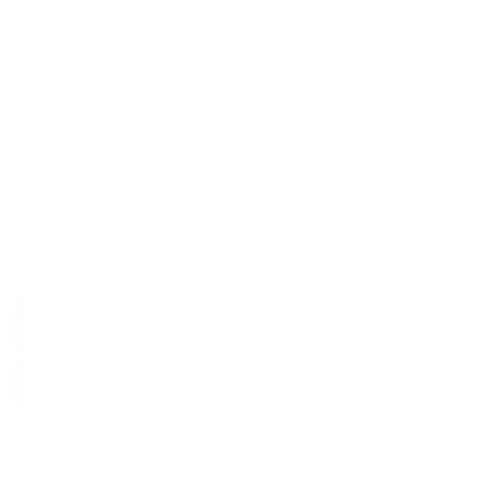

Image index: 1313 (Image ID: 3817)


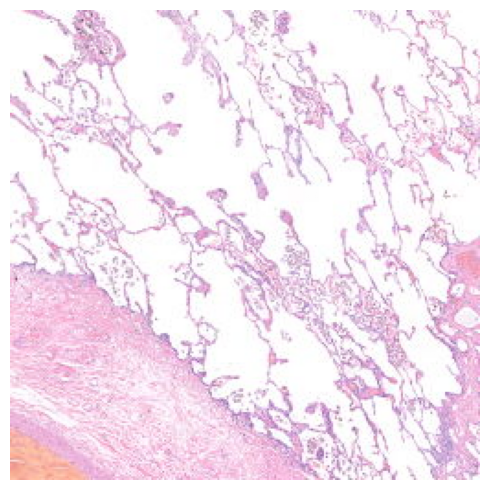

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.patches import Rectangle

def visualize_coco_samples(dataset, num_samples=3, indices=None, figsize=(15, 5), 
                          show_masks=True, show_boxes=True, show_labels=True,
                          mask_alpha=0.3, random_color=True):
    """
    Visualizes samples from COCO dataset with annotations.
    """
    if indices is None:
        # Get random indices
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        print(f"Image index: {idx} (Image ID: {dataset.image_ids[idx]})")
        image, target = dataset[idx]
        
        # If image is a tensor, convert to numpy array for visualization
        if isinstance(image, torch.Tensor):
            img = image.cpu().numpy().transpose(1, 2, 0)
            # Use consistent scaling - divide by 255 instead of min-max normalization
            img = img / 255.0
            # Clip to valid range
            img = np.clip(img, 0, 1)
        else:
            img = np.array(image) / 255.0
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=figsize)
        
        # Display image
        ax.imshow(img)
        
        # Get masks, boxes, and labels from target
        masks = target['masks']
        boxes = target['boxes']
        labels = target['labels']
        
        # Create a single combined overlay for all masks
        if show_masks and len(masks) > 0:
            # Initialize combined overlay
            h, w = masks[0].shape if len(masks) > 0 else img.shape[:2]
            combined_overlay = np.zeros((h, w, 4))  # RGBA image for overlay
            
            for i in range(len(masks)):
                if i < len(masks):
                    # Generate color for this instance
                    if random_color:
                        color = np.random.rand(3)
                    else:
                        cmap = plt.cm.get_cmap('tab10')
                        color = cmap(labels[i] % 10)[:3]
                    
                    # Add this mask to the combined overlay
                    mask = masks[i].cpu().numpy()
                    combined_overlay[mask == 1, :3] = color
                    combined_overlay[mask == 1, 3] = mask_alpha  # Set alpha channel
            
            # Apply the combined overlay
            ax.imshow(combined_overlay)
        
        # Display bounding boxes and labels
        for i in range(len(boxes)):
            # Generate color for this instance
            if random_color:
                color = np.random.rand(3)
            else:
                cmap = plt.cm.get_cmap('tab10')
                color = cmap(labels[i] % 10)[:3]
            
            # Display bounding box if requested
            if show_boxes and i < len(boxes):
                box = boxes[i].cpu().numpy()
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                rect = Rectangle((x1, y1), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Display category label if requested
                if show_labels:
                    category_id = labels[i].item()
                    category_name = dataset.categories.get(category_id, str(category_id))
                    ax.text(x1, y1-5, category_name, color=color, 
                           fontsize=10, backgroundcolor='white')
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

print("Training Dataset Examples:")
visualize_coco_samples(train_dataset, num_samples=2)

## Dataloaders

In [8]:
BATCH_SIZE = 32
NUM_WORKERS = 8

In [15]:
def classification_collate_fn(batch):
    """
    Custom collate function for to properly handle batching for classification tasks.
    """
    images = []
    labels = []
    
    for sample in batch:
        image, target = sample
        images.append(image)
        
        # For classification, we only need the label
        # Assuming the first label is the class we want to predict
        if 'labels' in target and len(target['labels']) > 0:
            labels.append(target['labels'][0])
        else:
            # Default to class 0 if no label is present
            labels.append(torch.tensor(0))
    
    # Stack images and labels into batches
    images = torch.stack(images, 0)
    labels = torch.stack(labels, 0)
    
    return images, {'labels': labels}

In [16]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=classification_collate_fn  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=classification_collate_fn
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


ℹ️ Created DataLoaders with batch size 32
	- Training batches: 152
	- Test batches: 38


# Training

## Model architecture

In [17]:
resnet = get_model_resnet34(num_classes=2, pretrained=True)

optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

Using cache found in /home/bolma/.cache/torch/hub/pytorch_vision_v0.10.0


## Training loop

In [22]:
import warnings

# For logging to comet.ml, a cloud service
load_dotenv()
api_key = os.getenv('COMET_API_KEY')
comet_logger = CometLogger(api_key=api_key,
                        project_name="msc-thesis",
                        experiment_name="ResNet",
                        log_env_details=False)

# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    # Training loop
    resnet_training_testing_loop(resnet, device, train_dataloader, test_dataloader, optimizer, n_epochs=30, comet_logger=comet_logger)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/bolf-marton/msc-thesis/a331c545cbec4cd8b0af58d5d4f2cfa2




🚀 STARTING TRAINING
-------------------
Epoch 1/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 17.14it/s]


Train – Loss: 0.0537, Accuracy: 97.98%


100%|██████████| 38/38 [00:01<00:00, 31.67it/s]


Test – Loss: 0.3075, Accuracy: 91.67%
-------------------
Epoch 2/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 17.14it/s]


Train – Loss: 0.0525, Accuracy: 98.12%


100%|██████████| 38/38 [00:01<00:00, 31.20it/s]


Test – Loss: 0.2131, Accuracy: 93.73%
-------------------
Epoch 3/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 17.10it/s]


Train – Loss: 0.0318, Accuracy: 99.18%


100%|██████████| 38/38 [00:01<00:00, 31.14it/s]


Test – Loss: 0.2446, Accuracy: 93.24%
-------------------
Epoch 4/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 16.99it/s]


Train – Loss: 0.0401, Accuracy: 98.43%


100%|██████████| 38/38 [00:01<00:00, 30.92it/s]


Test – Loss: 0.3236, Accuracy: 88.95%
-------------------
Epoch 5/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 17.02it/s]


Train – Loss: 0.0319, Accuracy: 98.80%


100%|██████████| 38/38 [00:01<00:00, 31.05it/s]


Test – Loss: 0.2634, Accuracy: 92.33%
-------------------
Epoch 6/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 17.00it/s]


Train – Loss: 0.0225, Accuracy: 99.18%


100%|██████████| 38/38 [00:01<00:00, 31.34it/s]


Test – Loss: 0.3046, Accuracy: 89.37%
-------------------
Epoch 7/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 16.99it/s]


Train – Loss: 0.0180, Accuracy: 99.46%


100%|██████████| 38/38 [00:01<00:00, 31.31it/s]


Test – Loss: 0.2519, Accuracy: 93.57%
-------------------
Epoch 8/30 - ResNet
-------------------


100%|██████████| 152/152 [00:08<00:00, 16.96it/s]


Train – Loss: 0.0288, Accuracy: 98.93%


100%|██████████| 38/38 [00:01<00:00, 31.37it/s]


Test – Loss: 0.2043, Accuracy: 93.32%
-------------------
Epoch 9/30 - ResNet
-------------------


100%|██████████| 152/152 [00:09<00:00, 16.88it/s]


Train – Loss: 0.0100, Accuracy: 99.67%


100%|██████████| 38/38 [00:01<00:00, 31.23it/s]


Test – Loss: 0.2368, Accuracy: 93.82%
--------------------
Epoch 10/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.81it/s]


Train – Loss: 0.0229, Accuracy: 99.18%


100%|██████████| 38/38 [00:01<00:00, 31.11it/s]


Test – Loss: 0.2776, Accuracy: 93.98%
--------------------
Epoch 11/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.88it/s]


Train – Loss: 0.0311, Accuracy: 98.80%


100%|██████████| 38/38 [00:01<00:00, 30.76it/s]


Test – Loss: 0.2816, Accuracy: 92.50%
--------------------
Epoch 12/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.83it/s]


Train – Loss: 0.0090, Accuracy: 99.61%


100%|██████████| 38/38 [00:01<00:00, 31.14it/s]


Test – Loss: 0.2089, Accuracy: 94.48%
--------------------
Epoch 13/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.84it/s]


Train – Loss: 0.0113, Accuracy: 99.61%


100%|██████████| 38/38 [00:01<00:00, 31.15it/s]


Test – Loss: 0.2288, Accuracy: 93.32%
--------------------
Epoch 14/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.84it/s]


Train – Loss: 0.0111, Accuracy: 99.55%


100%|██████████| 38/38 [00:01<00:00, 30.90it/s]


Test – Loss: 0.3397, Accuracy: 93.98%
--------------------
Epoch 15/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.81it/s]


Train – Loss: 0.0087, Accuracy: 99.69%


100%|██████████| 38/38 [00:01<00:00, 31.14it/s]


Test – Loss: 0.5400, Accuracy: 88.95%
--------------------
Epoch 16/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.84it/s]


Train – Loss: 0.0100, Accuracy: 99.67%


100%|██████████| 38/38 [00:01<00:00, 31.16it/s]


Test – Loss: 0.2328, Accuracy: 94.72%
--------------------
Epoch 17/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.79it/s]


Train – Loss: 0.0019, Accuracy: 99.96%


100%|██████████| 38/38 [00:01<00:00, 31.42it/s]


Test – Loss: 0.2341, Accuracy: 94.72%
--------------------
Epoch 18/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.82it/s]


Train – Loss: 0.0013, Accuracy: 100.00%


100%|██████████| 38/38 [00:01<00:00, 30.57it/s]


Test – Loss: 0.2532, Accuracy: 94.81%
--------------------
Epoch 19/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.43it/s]


Train – Loss: 0.0012, Accuracy: 99.96%


100%|██████████| 38/38 [00:01<00:00, 31.07it/s]


Test – Loss: 0.2288, Accuracy: 95.05%
--------------------
Epoch 20/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.84it/s]


Train – Loss: 0.0062, Accuracy: 99.79%


100%|██████████| 38/38 [00:01<00:00, 31.15it/s]


Test – Loss: 0.4227, Accuracy: 93.82%
--------------------
Epoch 21/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.85it/s]


Train – Loss: 0.0264, Accuracy: 98.99%


100%|██████████| 38/38 [00:01<00:00, 30.65it/s]


Test – Loss: 0.3562, Accuracy: 92.00%
--------------------
Epoch 22/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.87it/s]


Train – Loss: 0.0153, Accuracy: 99.48%


100%|██████████| 38/38 [00:01<00:00, 31.16it/s]


Test – Loss: 0.3115, Accuracy: 93.40%
--------------------
Epoch 23/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.83it/s]


Train – Loss: 0.0095, Accuracy: 99.73%


100%|██████████| 38/38 [00:01<00:00, 31.36it/s]


Test – Loss: 0.2425, Accuracy: 94.15%
--------------------
Epoch 24/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.82it/s]


Train – Loss: 0.0064, Accuracy: 99.77%


100%|██████████| 38/38 [00:01<00:00, 30.85it/s]


Test – Loss: 0.2264, Accuracy: 94.48%
--------------------
Epoch 25/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.80it/s]


Train – Loss: 0.0054, Accuracy: 99.75%


100%|██████████| 38/38 [00:01<00:00, 31.26it/s]


Test – Loss: 0.2507, Accuracy: 94.89%
--------------------
Epoch 26/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.80it/s]


Train – Loss: 0.0045, Accuracy: 99.88%


100%|██████████| 38/38 [00:01<00:00, 30.98it/s]


Test – Loss: 0.2526, Accuracy: 94.31%
--------------------
Epoch 27/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.83it/s]


Train – Loss: 0.0073, Accuracy: 99.71%


100%|██████████| 38/38 [00:01<00:00, 30.23it/s]


Test – Loss: 0.3849, Accuracy: 94.81%
--------------------
Epoch 28/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.78it/s]


Train – Loss: 0.0136, Accuracy: 99.61%


100%|██████████| 38/38 [00:01<00:00, 30.73it/s]


Test – Loss: 0.2730, Accuracy: 93.57%
--------------------
Epoch 29/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.85it/s]


Train – Loss: 0.0114, Accuracy: 99.61%


100%|██████████| 38/38 [00:01<00:00, 31.50it/s]


Test – Loss: 0.3148, Accuracy: 93.82%
--------------------
Epoch 30/30 - ResNet
--------------------


100%|██████████| 152/152 [00:09<00:00, 16.84it/s]


Train – Loss: 0.0231, Accuracy: 99.26%


100%|██████████| 38/38 [00:01<00:00, 31.41it/s]

Test – Loss: 0.2988, Accuracy: 92.83%


In [23]:
comet_logger.end() # End the comet logger session

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/a331c545cbec4cd8b0af58d5d4f2cfa2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [456]             : (4.0902932596509345e-06, 0.3221491575241089)
COMET INFO:     test_accuracy [30]     : (88.95300906842539, 95.05358615004123)
COMET INFO:     test_loss [30]         : (0.20430795143236333, 0.5399501860289169)
COMET INFO:     training_accuracy [30] : (97.97979797979798, 100.0)
COMET INFO:     training_loss [30]     : (0.001162153421524012, 0.05369442760087342)
COMET INFO:   Others:
COMET INFO:     Name : ResNet
COMET INFO:   Uploads:
COMET INFO:  

In [24]:
# Save the model weights
torch.save(resnet.state_dict(), "src/models/weights/ResNet_trained_weights.pth")